In [1]:
# Setup (Imports)

from LoadData import *

from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, LSTM, Dropout, Flatten, Conv1D, BatchNormalization, Activation, GlobalMaxPooling1D

import numpy as np

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Setup (Globals/Hyperz)

window_size  = 4
epochs       = 750
batch_size   = 128
emb_size     = 100

In [3]:
# Loading and Splitting Data

def get_data(stock):
    
    AllX, AllY = create_timeframed_doc2vec_classification_data(stock, window_size, min_time_disparity=4)
    
    trainX, trainY, testX, testY = split_data(AllX, AllY, ratio=.85)
    
    return (trainX, trainY), (testX, testY)


In [4]:
# Make Model

def get_model():
    
    model = Sequential()
    
    model.add(Conv1D(filters=8, kernel_size=3, padding='same', input_shape=(window_size, emb_size), name="hl_conv1d"))
    model.add(GlobalMaxPooling1D(name="hl_gpool"))
    
    #model.add(Dense(30,          name="hl_d1"))
    #model.add(BatchNormalization(name="hl_bn1"))
    #model.add(Activation('selu', name="hl_a1"))
    #model.add(Dropout(0.5,       name="hl_do1"))
    
    model.add(Dense(10,          name="hl_d2"))
    model.add(BatchNormalization(name="hl_bn2"))
    model.add(Activation('selu', name="hl_a2"))
    model.add(Dropout(0.2,       name="hl_do2"))
    
    model.add(Dense(8,          name="hl_d3"))
    model.add(BatchNormalization(name="hl_bn3"))
    model.add(Activation('selu', name="hl_a3"))
    model.add(Dropout(0.1,       name="hl_do3"))

    model.add(Dense(2, activation='softmax', name="hl_d4"))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    return model


In [5]:
# Run (Load)

if __name__ == "__main__":

    (trainX, trainY), (testX, testY) = get_data('AAPL')

    print(trainX.shape, trainY.shape)


(704, 4, 100) (704, 2)


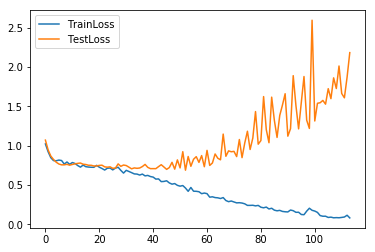

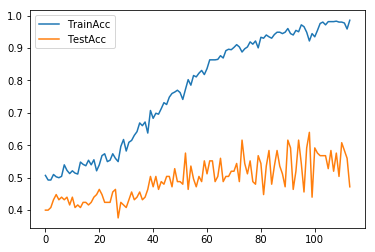

In [6]:
# Run (Train)

if __name__ == "__main__":

    model = get_model()

    reduce_LR = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=1e-6, verbose=0)
    e_stopping = EarlyStopping(patience=60)
    checkpoint = ModelCheckpoint(os.path.join('models', 'headline-classification.h5'), 
                                 monitor='val_loss', 
                                 verbose=0, 
                                 save_best_only=True)

    history = model.fit(trainX, trainY, epochs=epochs, 
                                        batch_size=batch_size, 
                                        validation_data=(testX, testY), 
                                        verbose=0, 
                                        callbacks=[checkpoint, e_stopping])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['TrainLoss', 'TestLoss'])
    plt.show()

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['TrainAcc', 'TestAcc'])
    plt.show()
